In [212]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import healpy as hp
import os
from tqdm import tqdm
sys.path.append('..')
import pickle as pl
import scipy.optimize as op
import corner
import emcee
from getdist import plots, MCSamples
import getdist
import matplotlib
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
from solat_cb.simulation import CMB, BandpassInt, Foreground, Mask, Noise, LATsky, SATsky
from solat_cb.spectra import Spectra

In [3]:
lib ='/pscratch/sd/l/lonappan/SOLATcalib'
nside = 512
lmax = 3*nside - 1
cb_method = 'iso'
beta = 0.35
dust = 10
synch = 5
alpha_sat = [0.05,0.05,-0.08,-0.08,.07,.07]
alpha_lat = [-0.1,-0.1,0.2,0.2,.15,.15]
atm_noise = True
nsplits = 1
bandpass = False
deconv_maps = False

In [4]:
lat = LATsky(lib,nside,cb_method,dust,synch,alpha_lat,beta,atm_noise=atm_noise,nsplits=nsplits,bandpass=bandpass,deconv_maps=deconv_maps)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic cosmic birefringence model selected
Mask : INFO - Downgrading mask LAT resolution
Noise : INFO - Noise Model:[LAT] White + 1/f noise v3.1.1


In [5]:
sat = SATsky(lib,nside,cb_method,dust,synch,alpha_sat,beta,atm_noise=atm_noise,nsplits=nsplits,bandpass=bandpass,deconv_maps=deconv_maps)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic cosmic birefringence model selected
Mask : INFO - Downgrading mask SAT resolution
/pscratch/sd/l/lonappan/software_pkgs/cb/lib/python3.10/site-packages/so_models_v3/SO_Noise_Calculator_Public_v3_1_1.py:215: RuntimeWarning: divide by zero encountered in scalar divide
  cov_weight[i,j] += ( tube_count * N_tels /
Noise : INFO - Noise Model:[SAT] White + 1/f noise v3.1.1


In [6]:
latspectra = Spectra(lat,parallel=2,galcut=40,binwidth=5)
satspectra = Spectra(sat,parallel=2,galcut=40,CO=False,PS=False,binwidth=5)

Spectra : INFO - Reading apodised mask from /pscratch/sd/l/lonappan/SOLATcalib/LAT_atm_noise_1splits/spectra_512_aposcale2p0_common/workspaces/mask_N512_aposcale2p0_CO_PS_G40.fits
Spectra : INFO - Reading coupling Matrix from /pscratch/sd/l/lonappan/SOLATcalib/LAT_atm_noise_1splits/spectra_512_aposcale2p0_common/workspaces/coupling_matrix_N512_fsky0p24_aposcale2p0_bw5_CO_PS_G40.fits
Spectra : INFO - Parallelized double loop
Spectra : INFO - Reading apodised mask from /pscratch/sd/l/lonappan/SOLATcalib/SAT_atm_noise_1splits/spectra_512_aposcale2p0_common/workspaces/mask_N512_aposcale2p0_G40.fits
Spectra : INFO - Reading coupling Matrix from /pscratch/sd/l/lonappan/SOLATcalib/SAT_atm_noise_1splits/spectra_512_aposcale2p0_common/workspaces/coupling_matrix_N512_fsky0p09_aposcale2p0_bw5_G40.fits
Spectra : INFO - Parallelized double loop


In [62]:
sat_bb_freq1 = satspectra.binInfo.bin_cell(hp.gauss_beam(np.radians(satspectra.lat.fwhm[2]/60),lmax))
sat_bb_freq2 = satspectra.binInfo.bin_cell(hp.gauss_beam(np.radians(satspectra.lat.fwhm[3]/60),lmax))
sat_freq1, sat_freq2 = [], []
for i in range(50):
    sp = satspectra.obs_x_obs(i)
    sat_freq1.append(sp[2,2,2][2:]/sat_bb_freq1**2)
    sat_freq2.append(sp[3,3,2][2:]/sat_bb_freq2**2)
sat_freq1 = np.array(sat_freq1)
sat_freq2 = np.array(sat_freq2)

In [118]:
lat_bb_freq1 = latspectra.binInfo.bin_cell(hp.gauss_beam(np.radians(latspectra.lat.fwhm[2]/60),lmax)**2)
lat_bb_freq2 = latspectra.binInfo.bin_cell(hp.gauss_beam(np.radians(latspectra.lat.fwhm[3]/60),lmax)**2)
lat_freq1, lat_freq2 = [], []
for i in range(50):
    sp = latspectra.obs_x_obs(i)
    lat_freq1.append(sp[2,2,2][2:]/lat_bb_freq1)
    lat_freq2.append(sp[3,3,2][2:]/lat_bb_freq2)
lat_freq1 = np.array(lat_freq1)
lat_freq2 = np.array(lat_freq2)

In [9]:
cl_len = CMB(lib,nside,).get_lensed_spectra(dl=False)
b = satspectra.binInfo.get_effective_ells()

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic cosmic birefringence model selected


In [16]:
def theory(beta):
    th = 0.5 * (cl_len["ee"] - cl_len["bb"]) * np.sin(np.deg2rad(4 * beta))
    return satspectra.binInfo.bin_cell(th[:lmax+1])

def chisq_sat(theta):
    beta,alpha = theta
    model = theory(beta+alpha)
    chisq_freq1 = np.sum(((sat_freq1.mean(axis=0) - model)/sat_freq1.std(axis=0))**2)
    chisq_freq2 = np.sum(((sat_freq2.mean(axis=0) - model)/sat_freq2.std(axis=0))**2)
    return chisq_freq1 + chisq_freq2

def lnprior_sat(theta):
    beta,alpha = theta
    mu = -0.08
    sigma = 0.08
    lnp = -0.5 * (alpha - mu)**2 / sigma**2
    if -0.5 < beta < 0.5:
        return lnp
    return -np.inf

def ln_likelihood_sat(theta):
    return -0.5 * chisq_sat(theta)

def ln_prob_sat(theta):
    lp = lnprior_sat(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood_sat(theta)

In [72]:
pos = np.array([0.3,-0.1]) + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob_sat, threads=4)
sample = sampler.run_mcmc(pos, 2000, progress=True)

100%|██████████| 2000/2000 [00:12<00:00, 164.74it/s]


In [73]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [74]:
np.mean(flat_samples[:,1]),np.std(flat_samples[:,1])

(-0.07688834609597621, 0.07537111086734366)

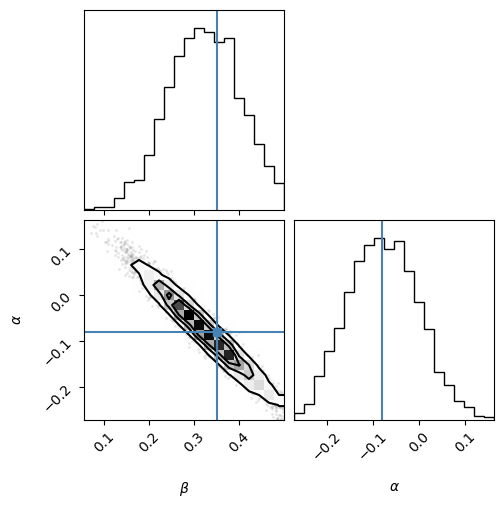

In [75]:
fig = corner.corner(flat_samples, labels=[r"$\beta$", r"$\alpha$"], truths=[0.35, -0.08])

In [141]:
select = np.where((b>10) & (b<1000))[0]

In [151]:
def chisq_diff(theta):
    alphalat,alphasat = theta
    model = theory(alphalat - alphasat)
    diff_freq1 = lat_freq1 - sat_freq1
    diff_freq2 = lat_freq2 - sat_freq2
    chisq_freq1 = np.sum((diff_freq1.mean(axis=0) - model)/diff_freq1.std(axis=0))**2
    chisq_freq2 = np.sum((diff_freq2.mean(axis=0) - model)/diff_freq2.std(axis=0))**2
    return chisq_freq1 + chisq_freq2

def lnprior_diff(theta):
    alphalat,alphasat = theta
    mu = -0.08
    sigma = 0.08
    lnp = -0.5 * (alphasat - mu)**2 / sigma**2 - np.log(sigma*np.sqrt(2*np.pi))
    if -0.5 < alphalat < 0.5:
        return lnp
    return -np.inf

def ln_likelihood_diff(theta):
    return -0.5 * chisq_diff(theta)

def ln_prob_diff(theta):
    lp = lnprior_diff(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood_diff(theta)

In [152]:
pos = np.array([0.2,-0.08]) + 1e-3 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob_diff, threads=4)
sample = sampler.run_mcmc(pos, 2000, progress=True)

100%|██████████| 2000/2000 [00:13<00:00, 143.39it/s]


In [153]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [157]:
np.mean(flat_samples[:,0]),np.std(flat_samples[:,0])

(0.17948272886392105, 0.08023791255455905)

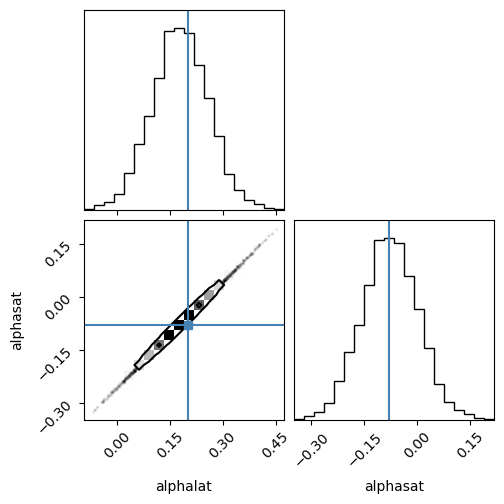

In [155]:
fig = corner.corner(flat_samples, labels=["alphalat",'alphasat'], truths=[0.2, -0.08])

In [196]:
select = np.where((b>10) & (b<700))[0]

In [197]:
def chisq_diff_sat(theta):
    alphalat,alphasat,beta = theta
    model_diff = theory(alphalat - alphasat)
    diff_freq1 = lat_freq1 - sat_freq1
    diff_freq2 = lat_freq2 - sat_freq2
    chisq_freq1 = np.sum((diff_freq1.mean(axis=0)[select] - model_diff[select])/diff_freq1.std(axis=0)[select])**2
    chisq_freq2 = np.sum((diff_freq2.mean(axis=0)[select] - model_diff[select])/diff_freq2.std(axis=0)[select])**2
    model_sat = theory(beta+alphasat)
    chisq_freq1_sat = np.sum(((sat_freq1.mean(axis=0)[select] - model_sat[select])/sat_freq1.std(axis=0)[select])**2)
    chisq_freq2_sat = np.sum(((sat_freq2.mean(axis=0)[select] - model_sat[select])/sat_freq2.std(axis=0)[select])**2)
    model_lat = theory(beta+alphalat)
    chisq_freq1_lat = np.sum(((lat_freq1.mean(axis=0)[select] - model_lat[select])/lat_freq1.std(axis=0)[select])**2)
    chisq_freq2_lat = np.sum(((lat_freq2.mean(axis=0)[select] - model_lat[select])/lat_freq2.std(axis=0)[select])**2)
    return chisq_freq1 + chisq_freq2 + chisq_freq1_sat + chisq_freq2_sat + chisq_freq1_lat + chisq_freq2_lat


def lnprior_diff_sat(theta):
    alphalat,alphasat,beta = theta
    mu = -0.08
    sigma = 0.07
    lnp = -0.5 * (alphasat - mu)**2 / sigma**2 - np.log(sigma*np.sqrt(2*np.pi))
    if -0.5 < alphalat < 0.5 and -0.5 < beta < 0.5:
        return lnp
    return -np.inf

def ln_likelihood_diff_sat(theta):
    return -0.5 * chisq_diff_sat(theta)

def ln_prob_diff_sat(theta):
    lp = lnprior_diff_sat(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood_diff_sat(theta)

In [198]:
pos = np.array([0.2,-0.08,0.35]) + 1e-3 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob_diff_sat, threads=4)
sample = sampler.run_mcmc(pos, 2000, progress=True)

100%|██████████| 2000/2000 [00:35<00:00, 55.88it/s]


In [199]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [241]:
flatsamples = MCSamples(samples=flat_samples,names = ['alat','asat','beta'], labels = [r'\alpha_{lat}',r'\alpha_{sat}',r'\beta'])

Removed no burn in


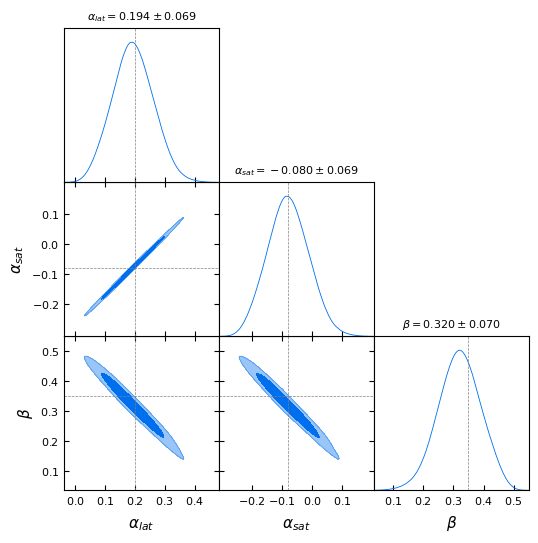

In [244]:
g = plots.get_subplot_plotter()
g.triangle_plot([flatsamples], filled=True,title_limit=1,markers={'alat':0.2,'asat':-0.08,'beta':0.35})
plt.savefig('triangle.pdf',bbox_inches='tight',dpi=300)

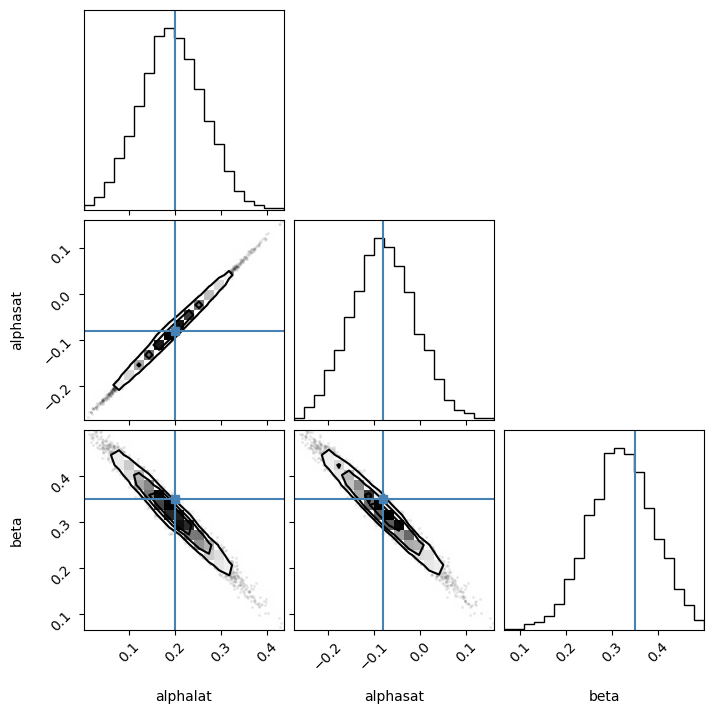

In [201]:
fig = corner.corner(flat_samples, labels=["alphalat",'alphasat','beta'], truths=[0.2, -0.08, 0.35])